In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import datetime
import folium
import folium.plugins
from shapely.geometry import Point
import cartopy.crs as ccrs 



In [ ]:
def year_day_to_datetime(year, day_of_year):
  """Converts a year and day of year to a datetime object.

  Args:
    year: The year (e.g., 2023).
    day_of_year: The day of the year (1-365 or 1-366 for leap years).

  Returns:
    A datetime object representing the given year and day of year.
  """
  try:
    datetime_object = datetime.datetime.strptime(f'{year}-{day_of_year}', '%Y-%j')
    return datetime_object
  except ValueError:
    print(f"Invalid date: {year}-{day_of_year}")
    return None  # Handle cases with invalid day of year
  


2023-04-10 00:00:00
2024-01-01 00:00:00


In [ ]:
### Load the data form a csv
df = pd.read_csv('../Data/Firegrowth_groups_v1_01.csv')
df.columns

#drop all columns but latitude, longitude, cumulative area, and fire name, year and DOB
df = df[['lon', 'lat', 'ID', 'year', 'DOB', 'cumuarea']]

#remove all rows with NaN values
df = df.dropna()

df = df.drop_duplicates(subset=['ID'], keep='last')

df['datetime'] = df.apply(lambda row: year_day_to_datetime(row['year'], row['DOB']), axis=1)
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d', errors='coerce')

#make it a geodataframe
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.crs = 'EPSG:4326'

gdf.head()


,lon,lat,ID,year,DOB,cumuarea,datetime,geometry
4,-116.459958,56.777929,2002_109,2002,179,9833.40,2002-06-28,POINT (-116.45996 56.77793)
11,-128.739971,60.834966,2002_11,2002,173,6097.68,2002-06-22,POINT (-128.73997 60.83497)
14,-114.745446,57.049854,2002_116,2002,178,8505.00,2002-06-27,POINT (-114.74545 57.04985)
31,-115.065407,56.768829,2002_130,2002,191,3943.08,2002-07-10,POINT (-115.06541 56.76883)
32,-109.603870,57.584611,2002_131,2002,194,1584.36,2002-07-13,POINT (-109.60387 57.58461)


Original GeoDataFrame snippet:
           lon        lat        ID  year  DOB  cumuarea   datetime  \
4  -116.459958  56.777929  2002_109  2002  179   9833.40 2002-06-28   
11 -128.739971  60.834966   2002_11  2002  173   6097.68 2002-06-22   
14 -114.745446  57.049854  2002_116  2002  178   8505.00 2002-06-27   
31 -115.065407  56.768829  2002_130  2002  191   3943.08 2002-07-10   
32 -109.603870  57.584611  2002_131  2002  194   1584.36 2002-07-13   

                       geometry  grid_lon_corner  grid_lat_corner  \
4   POINT (-116.45996 56.77793)          -116.50            56.75   
11  POINT (-128.73997 60.83497)          -128.75            60.75   
14  POINT (-114.74545 57.04985)          -114.75            57.00   
31  POINT (-115.06541 56.76883)          -115.25            56.75   
32  POINT (-109.60387 57.58461)          -109.75            57.50   

    centroid_lon  centroid_lat  month  
4       -116.375        56.875      6  
11      -128.625        60.875      6  
14     

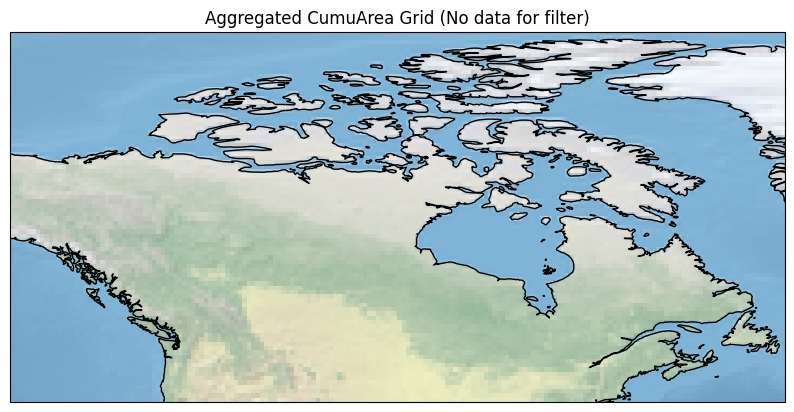

In [22]:




print("Original GeoDataFrame snippet:")
print(gdf.head())
print(f"\nOriginal CRS: {gdf.crs}")

# --- 2. Calculate Target Grid Centroid for Each Point ---
grid_res = 0.25
centroid_offset = grid_res / 2.0  # 0.125

# Calculate the bottom-left corner of the grid cell each point falls into
gdf['grid_lon_corner'] = np.floor(gdf.geometry.x / grid_res) * grid_res
gdf['grid_lat_corner'] = np.floor(gdf.geometry.y / grid_res) * grid_res

# Calculate the centroid of that grid cell
gdf['centroid_lon'] = gdf['grid_lon_corner'] + centroid_offset
gdf['centroid_lat'] = gdf['grid_lat_corner'] + centroid_offset

# --- 3. Extract Temporal Information ---
gdf['month'] = gdf['datetime'].dt.month


# --- 4. Group and Aggregate ---
# Group by the calculated centroid coordinates, year, and month
aggregated_data = gdf.groupby(['centroid_lon', 'centroid_lat', 'year', 'month'])['cumuarea'].sum()

# Convert the result (Pandas Series with MultiIndex) back to a DataFrame
aggregated_df = aggregated_data.reset_index()

print("\nAggregated data (DataFrame format):")
print(aggregated_df.head())

# --- 5. Create Final Grid GeoDataFrame ---
# Create Point geometries from the centroid coordinates
geometry = [Point(xy) for xy in zip(aggregated_df['centroid_lon'], aggregated_df['centroid_lat'])]

# Create the final GeoDataFrame
grid_gdf = gpd.GeoDataFrame(aggregated_df, geometry=geometry, crs=gdf.crs) # Use original CRS

# Optional: Drop intermediate columns if desired
# grid_gdf = grid_gdf.drop(columns=['centroid_lon', 'centroid_lat'])

print("\nFinal Aggregated Grid GeoDataFrame snippet:")
print(grid_gdf.head())
print(f"\nFinal Grid CRS: {grid_gdf.crs}")

#* --- Optional: Visualization ---


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) # Use PlateCarree for lon/lat
ax.stock_img() # Add background continents/oceans
ax.coastlines()

# Plot grid centroids, size/color by cumuarea
# Filter for a specific month/year for clarity if needed
plot_data = grid_gdf[(grid_gdf['year'] == 2002) & (grid_gdf['month'] == 2)] # Example filter

if not plot_data.empty:
    plot_data.plot(ax=ax, marker='o', column='cumuarea', cmap='viridis', markersize=(plot_data['cumuarea']/plot_data['cumuarea'].max())*100 + 10, legend=True, transform=ccrs.Geodetic()) # Specify transform
    ax.set_extent([-142, -52, 41, 84], crs=ccrs.PlateCarree()) # Approximate Canada extent
    ax.set_title(f"Aggregated CumuArea Grid (Example: June 2002)")
else:
    print("\nNo data to plot for the selected filter.")
    ax.set_extent([-142, -52, 41, 84], crs=ccrs.PlateCarree())
    ax.set_title("Aggregated CumuArea Grid (No data for filter)")

plt.show()

# --- Optional: Save to file ---
grid_gdf.to_file("../Data/aggregated_wildfire_grid.gpkg", driver="GPKG")
grid_gdf.to_csv("../Data/aggregated_wildfire_grid.csv", index=False)
# grid_gdf.to_file("aggregated_grid.shp")